# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append('./..')
sys.path.append('./../..')
import logging

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact

import dynaphos
from dynaphos import utils
from dynaphos import cortex_models
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator


import math

# Simulator

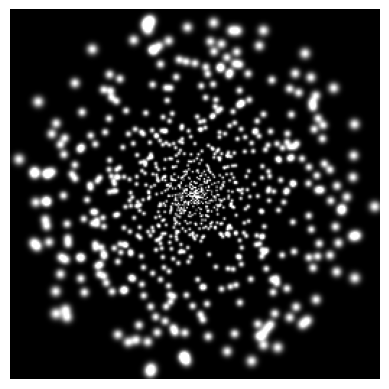

In [2]:
# Load the simulator configuration file (and adjust to preferences).
params = utils.load_params('../config/params.yaml')

# Get phosphene coordinates...
n_phosphenes = 1024
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)

# Initialize simulator
simulator = PhospheneSimulator(params, phosphene_coords)

# Stimulation amplitude
amplitude = params['sampling']['stimulus_scale'] # Ampère (160 µA)

# Stimulation vector
stim = amplitude * torch.ones(n_phosphenes).cuda().detach() # (All electrodes are activated)

# Reset and call the simulator
simulator.reset()
phosphenes = simulator(stim)

# Show the phosphene image
plt.imshow(phosphenes.cpu(), cmap='gray')
plt.axis('off')
plt.show()

# Uniformity

In [3]:
from phosphene.uniformity import DynamicAmplitudeNormalizer

Loss = 0.0267:   0%|                                                                                                                                                                                                  | 0/2000 [00:00<?, ?iter/s]

Loss = 0.0020: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 233.68iter/s]


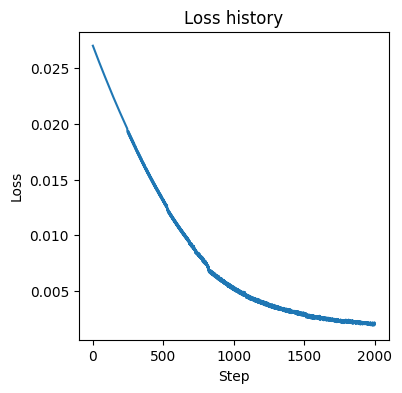

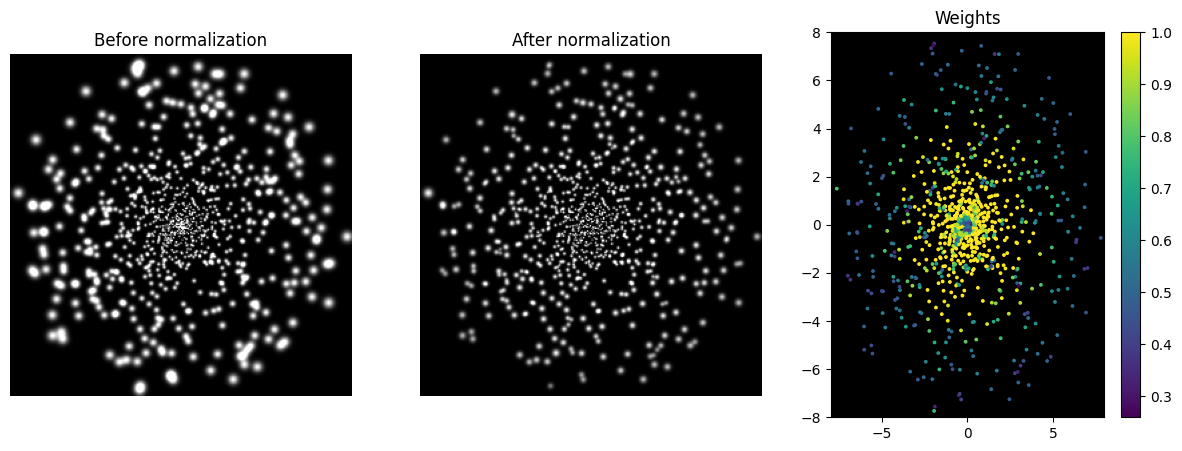

Percentage of amplitude: 76.56%


In [4]:
stim_init = amplitude * torch.ones(simulator.num_phosphenes, device='cuda')

normalizer = DynamicAmplitudeNormalizer(
    simulator=simulator,
    base_size=3,
    scale=0.0001,
    A_min=0,
    A_max=amplitude,
    learning_rate=0.002,
    steps=2000,
    target=None  # or a specific float
)
stim_final = normalizer.run(stim_init, verbose=True)
stim_weights = normalizer.weights

# plot the loss_history from the normalizer
plt.figure(figsize=(4, 4))
plt.plot(normalizer.loss_history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss history')
plt.show()

# Visualize
simulator.reset()
phos_image_before = simulator(stim_init)
simulator.reset()
phos_image_after  = simulator(stim_init * stim_weights)

# visualize the phosphene images and the weights in a scatterplot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(phos_image_before.cpu(), cmap='gray')
plt.axis('off')
plt.title('Before normalization')

plt.subplot(1, 3, 2)
plt.imshow(phos_image_after.cpu(), cmap='gray')
plt.axis('off')
plt.title('After normalization')

plt.subplot(1, 3, 3)
phosphene_coords = simulator.coordinates
plt.scatter(phosphene_coords._x, -phosphene_coords._y, c=stim_weights.cpu(), cmap='viridis', s=3)
# extend the axes to the full image size
fov = simulator.params['run']['view_angle']
plt.xlim(-fov/2, fov/2)
plt.ylim(-fov/2, fov/2)
# black background
plt.gca().set_facecolor('black')
plt.colorbar()
plt.title('Weights')
plt.show()

# percentage of amplitude compared to full amplitude
print(f'Percentage of amplitude: {stim_weights.sum() / simulator.num_phosphenes*100:.2f}%')

# Phosphene Density Maps

In [5]:
from phosphene.density import VisualFieldMapper

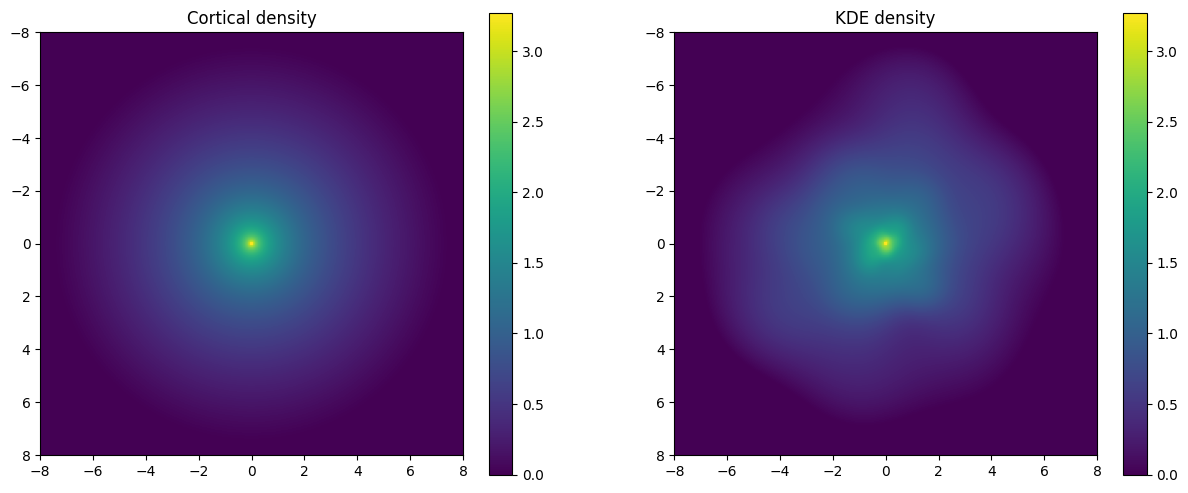

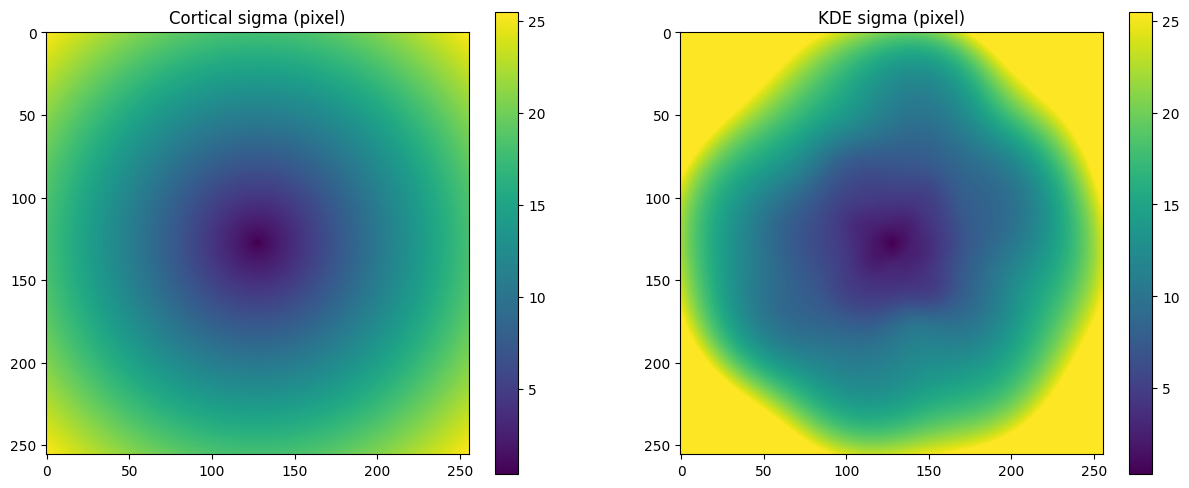

In [6]:
mapper = VisualFieldMapper(simulator=simulator)

# 1) Cortical approach:
density_cortical = mapper.build_density_map_cortical(total_phosphenes=1024)
sigma_cortical_fov = mapper.build_sigma_map_from_density(density_cortical, space="fov")
sigma_cortical_pix = mapper.build_sigma_map_from_density(density_cortical, space="pixel")

# 2) KDE approach:
density_kde = mapper.build_density_map_kde(k=16, alpha=1.0, total_phosphenes=1024)
sigma_kde_fov = mapper.build_sigma_map_from_density(density_kde, space="fov")
sigma_kde_pix = mapper.build_sigma_map_from_density(density_kde, space="pixel")

# show density maps
fov = params['run']['view_angle']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.log10(density_cortical), cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmin=0)
plt.colorbar()
plt.title('Cortical density')

plt.subplot(1, 2, 2)
plt.imshow(np.log10(density_kde), cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmax=np.log10(density_cortical.max()), vmin=0)
plt.colorbar()
plt.title('KDE density')
plt.show()

# plot sigma_cortical_pix, sigma_kde_pix
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(sigma_cortical_pix, cmap='viridis')
plt.colorbar()
plt.title('Cortical sigma (pixel)')

plt.subplot(1, 2, 2)
plt.imshow(sigma_kde_pix, cmap='viridis', vmax=sigma_cortical_pix.max())
plt.colorbar()
plt.title('KDE sigma (pixel)')
plt.show()

# Image processing for Phosphene Vision

In [7]:
from data.local_datasets import LaPaDataset
from spatial_frequency.components.modulated_conv2d import UnifiedInputModulation
import yaml

def load_config(yaml_file):
    with open(yaml_file) as file:
        raw_content = yaml.load(file,Loader=yaml.FullLoader) # nested dictionary
    return {k:v for params in raw_content.values() for k,v in params.items()} # unpacked


cfg = load_config('../config/256x256_LaPa.yaml')
LaPa_dataset = LaPaDataset(cfg)

In [16]:
def robust_percentile_normalization(electrode, amplitude, threshold, low_perc=5, high_perc=95, gamma=1.0):
    """
    Normalize the stimulation vector in a robust, contrast-preserving way.

    This function performs the following steps:
      1. Subtracts a given threshold (values below threshold become 0).
      2. Computes low and high percentiles (e.g., 5th and 95th) of the resulting values.
      3. Linearly scales values between these percentiles to [0, 1], then applies an optional gamma correction.
      4. Scales the result to the desired amplitude.

    Args:
        electrode (torch.Tensor): Input stimulation values.
        amplitude (float): Desired maximum amplitude.
        threshold (float): Activation threshold (e.g. your activation_threshold).
        low_perc (float): Lower percentile (default 5).
        high_perc (float): Upper percentile (default 95).
        gamma (float): Gamma exponent for power-law scaling (default 1.0 means linear scaling).
        
    Returns:
        torch.Tensor: Normalized stimulation values, with zeros preserved.
    """
    # Subtract threshold and clamp to 0 so that values below threshold remain 0.
    above_thresh = electrode - threshold
    above_thresh = torch.clamp(above_thresh, min=0.0)
    
    # Compute robust lower and upper bounds using percentiles.
    # Use torch.quantile (available in PyTorch 1.7+; adjust if needed).
    low_val = torch.quantile(above_thresh, low_perc / 100.0)
    high_val = torch.quantile(above_thresh, high_perc / 100.0)
    
    # Avoid division by zero if high_val == low_val.
    range_val = high_val - low_val + 1e-8

    # Linearly map values in the range [low_val, high_val] to [0, 1]
    normalized = (above_thresh - low_val) / range_val
    normalized = torch.clamp(normalized, 0.0, 1.0)

    # Apply gamma correction to adjust contrast if needed.
    normalized = normalized ** gamma

    # Scale to the desired amplitude.
    normalized = normalized * amplitude

    return normalized


# Dilation is used for the reg-loss on the phosphene image: phosphenes do not have to map 1 on 1, small offset is allowed.
def dilation5x5(img, kernel=None):
    if kernel is None:
        kernel = torch.tensor([[[[0., 0., 1., 0., 0.],
                              [0., 1., 1., 1., 0.],
                              [1., 1., 1., 1., 1.],
                              [0., 1., 1., 1., 0.],
                              [0., 0., 1., 0., 0.]]]], requires_grad=False, device=img.device)
    return torch.clamp(torch.nn.functional.conv2d(img, kernel, padding=kernel.shape[-1]//2), 0, 1)

def dilation3x3(img, kernel=None):
    if kernel is None:
        kernel = torch.tensor([[[
                              [ 0, 1., 0.],
                              [ 1., 1., 1.],
                              [ 0., 1., 0.],]]], requires_grad=False, device=img.device)
    return torch.clamp(torch.nn.functional.conv2d(img, kernel, padding=kernel.shape[-1]//2), 0, 1)

In [9]:
sigma_map_tensor = torch.tensor(sigma_cortical_pix).float().cuda().detach()

layer = UnifiedInputModulation(
    kernel_size=119,
    kernel_type="log",
    sigma_map=sigma_map_tensor,
    dilation=1,
    padding_mode='reflect'
).cuda()
layer.eval()

UnifiedInputModulation()

We are going to compare 3 types of image processing:
- Input image thresholding
- Ground truth outlines
- LoG filtered

We will calculate the SSIM between the input and the phosphene images.
We will also calculate the SSIM between the phosphene images and the filtered images.

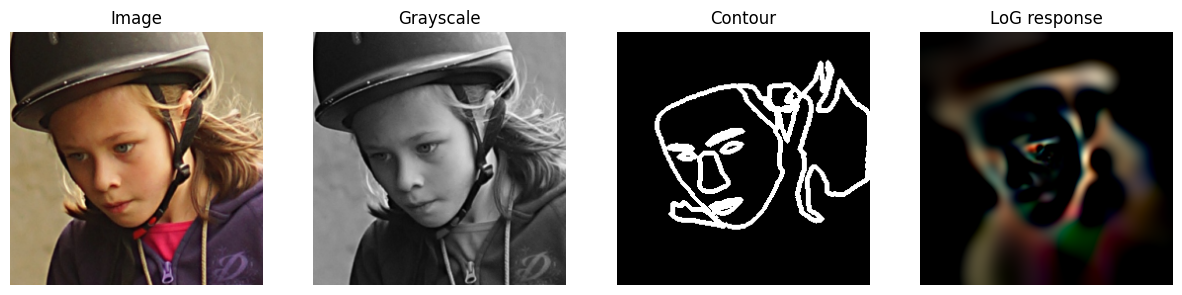

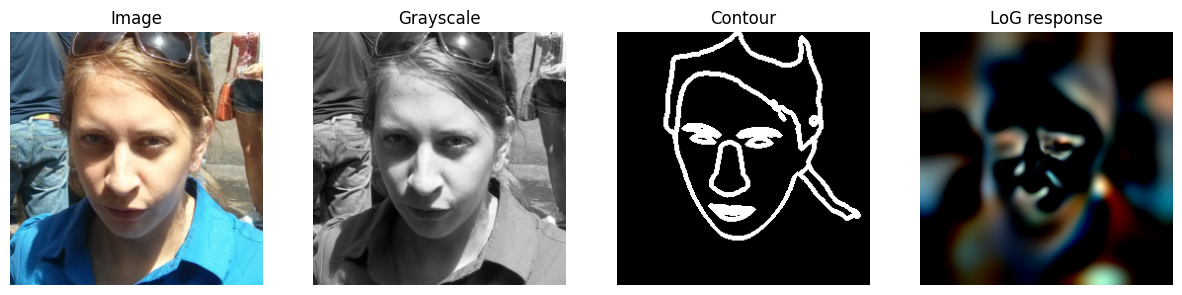

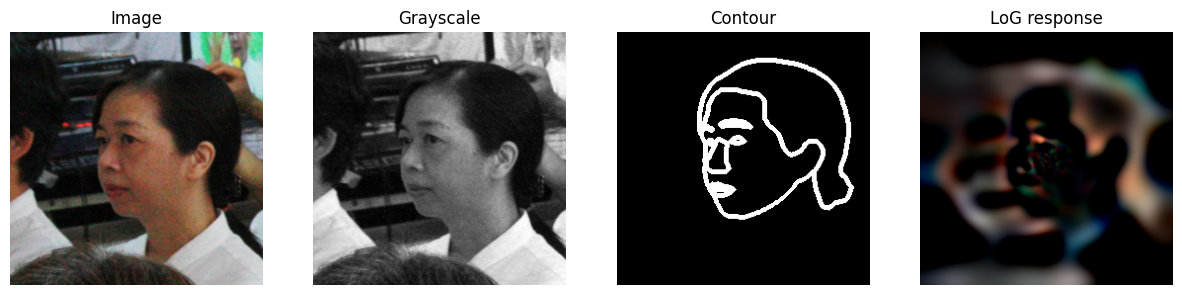

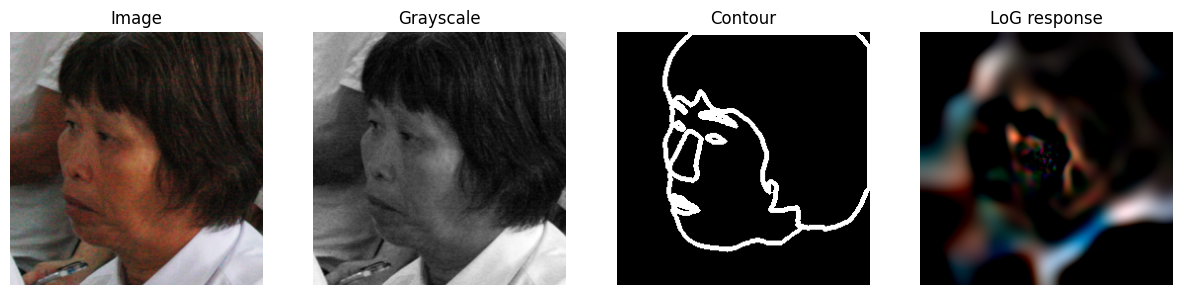

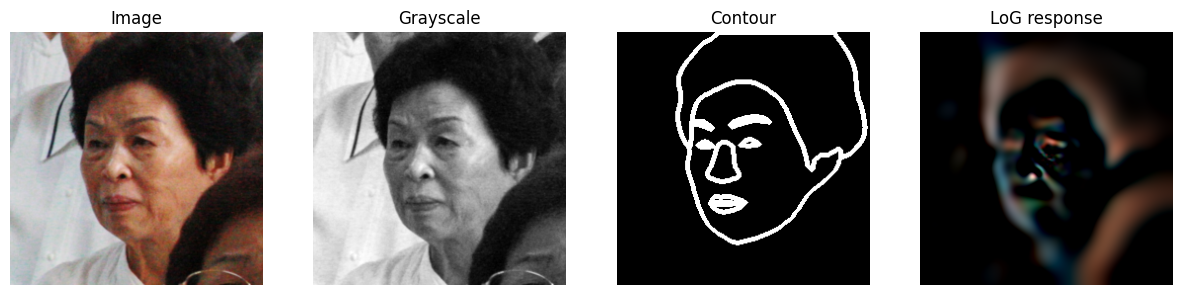

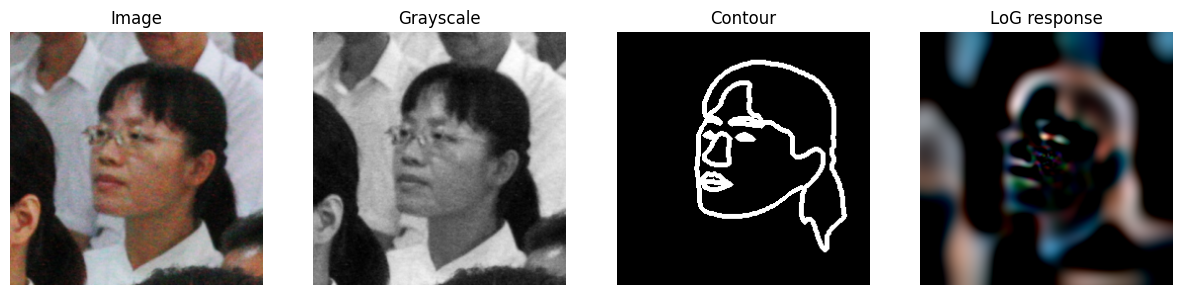

In [10]:
image_processing_dict = {}

for i, batch in enumerate(LaPa_dataset):
    image = batch['image']
    contour = batch['contour'] 

    # dilate the contour 5x5
    contour = dilation5x5(contour.unsqueeze(0)).squeeze(0)
    # contour = modified_cdf_normalization(contour, 1)

    LoG_response = layer(image.unsqueeze(0)).clip(0, None).squeeze(0)
    LoG_response = (LoG_response - LoG_response.min()) / (LoG_response.max() - LoG_response.min())
    # LoG_response = modified_cdf_normalization(LoG_response, 1)

    grayscale = image.mean(dim=0)
    # grayscale = modified_cdf_normalization(grayscale, 1)

    image_processing_dict[i] = {'image': image, 'grayscale': grayscale, 'contour': contour, 'LoG_response': LoG_response}

    # visualize
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(image.cpu().permute(1, 2, 0))
    plt.axis('off')
    plt.title('Image')

    plt.subplot(1, 4, 2)
    plt.imshow(grayscale.cpu(), cmap='gray')
    plt.axis('off')
    plt.title('Grayscale')

    plt.subplot(1, 4, 3)
    plt.imshow(contour.cpu().permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.title('Contour')

    plt.subplot(1, 4, 4)
    plt.imshow(LoG_response.squeeze().cpu().detach().permute(1,2,0))
    plt.axis('off')
    plt.title('LoG response')
    plt.show()
    
    if i == 5:
        break

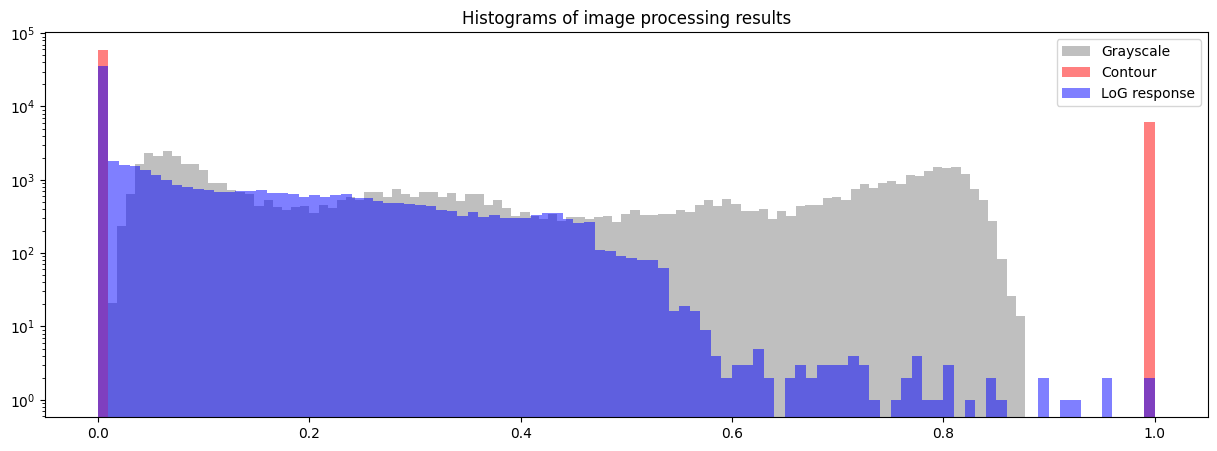

In [17]:
# show the histograms of the image processing results
i = 4
plt.figure(figsize=(15, 5))
plt.hist(image_processing_dict[i]['grayscale'].cpu().flatten(), bins=100, color='gray', alpha=0.5, label='Grayscale')
plt.hist(image_processing_dict[i]['contour'].cpu().flatten(), bins=100, color='red', alpha=0.5, label='Contour')
plt.hist(image_processing_dict[i]['LoG_response'].max(0).values.cpu().flatten(), bins=100, color='blue', alpha=0.5, label='LoG response')
plt.legend()
plt.yscale('log')
plt.title('Histograms of image processing results')

plt.show()

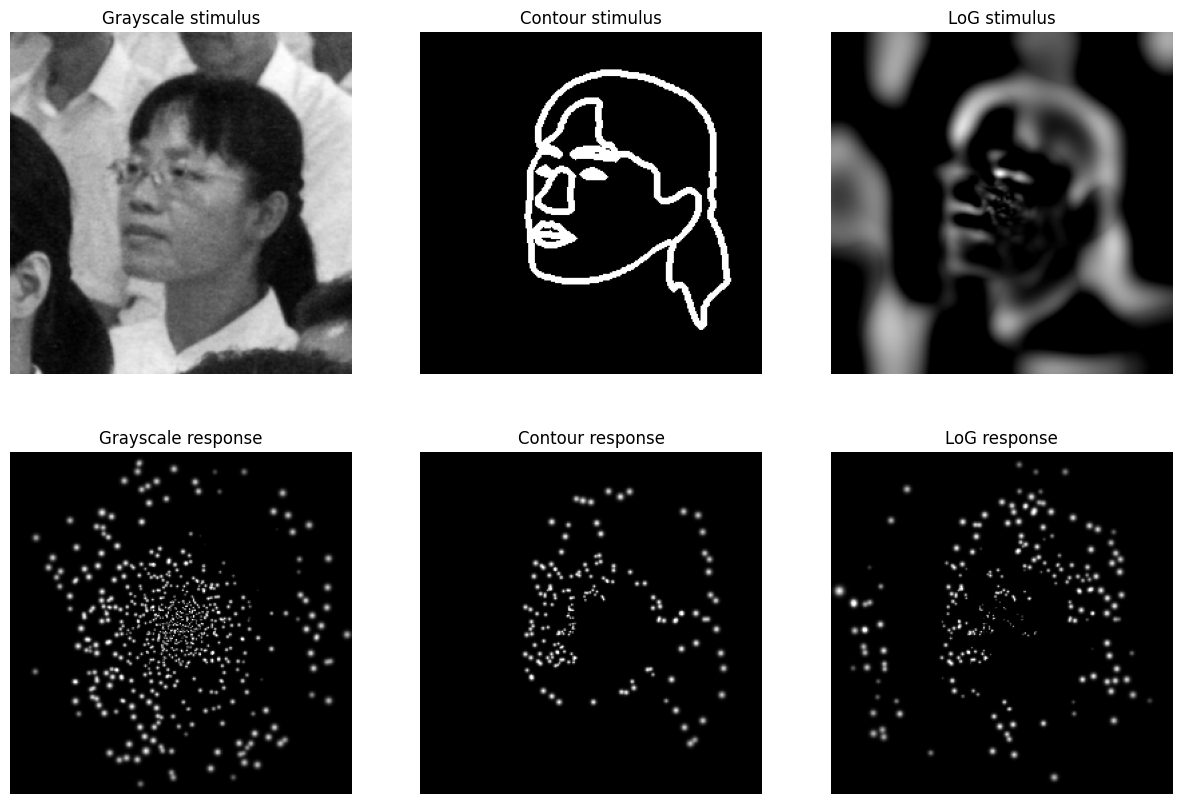

In [24]:
# use grayscale, contour and LoG response as phosphene stimuli and compare the responses
i = 5
threshold = params['thresholding']['rheobase']

# 1) Grayscale
simulator.reset()
grayscale_stim = image_processing_dict[i]['grayscale']
grayscale_electrode = simulator.sample_stimulus(grayscale_stim, rescale=True)
grayscale_electrode = robust_percentile_normalization(grayscale_electrode, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
grayscale_electrode = grayscale_electrode * stim_weights
grayscale_response = simulator(grayscale_electrode)

# 2) Contour
simulator.reset()
contour_stim = image_processing_dict[i]['contour']
contour_electrode = simulator.sample_stimulus(contour_stim, rescale=True)
contour_electrode = robust_percentile_normalization(contour_electrode, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
contour_electrode = contour_electrode * stim_weights
contour_response = simulator(contour_electrode)

# 3) LoG response
simulator.reset()
LoG_stim = image_processing_dict[i]['LoG_response'].max(0).values
LoG_electrode = simulator.sample_stimulus(LoG_stim, rescale=True)
LoG_electrode = robust_percentile_normalization(LoG_electrode, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
LoG_electrode = LoG_electrode * stim_weights
LoG_response = simulator(LoG_electrode)

# visualize
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.imshow(grayscale_stim.cpu(), cmap='gray')
plt.axis('off')
plt.title('Grayscale stimulus')

plt.subplot(2, 3, 2)
plt.imshow(contour_stim.squeeze(0).cpu(), cmap='gray')
plt.axis('off')
plt.title('Contour stimulus')

plt.subplot(2, 3, 3)
plt.imshow(LoG_stim.cpu(), cmap='gray')
plt.axis('off')
plt.title('LoG stimulus')

plt.subplot(2, 3, 4)
plt.imshow(grayscale_response.cpu(), cmap='gray')
plt.axis('off')
plt.title('Grayscale response')

plt.subplot(2, 3, 5)
plt.imshow(contour_response.cpu(), cmap='gray')
plt.axis('off')
plt.title('Contour response')

plt.subplot(2, 3, 6)
plt.imshow(LoG_response.cpu(), cmap='gray')
plt.axis('off')
plt.title('LoG response')

plt.show()

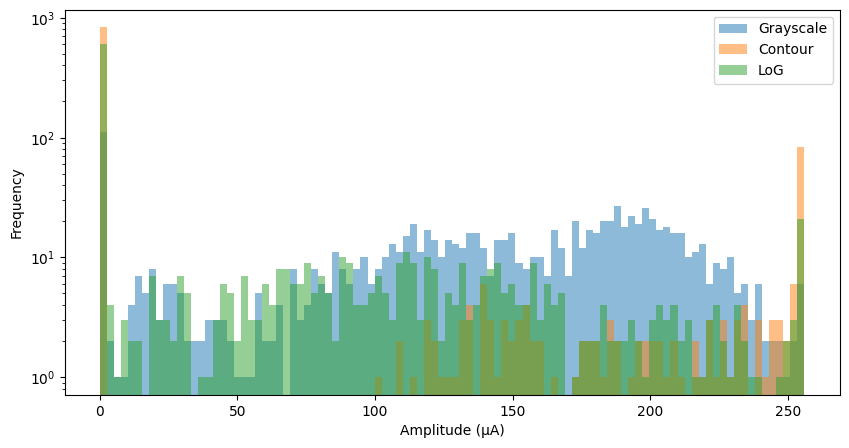

In [28]:
# see the histograms of grayscale_electrode, contour_electrode and LoG_electrode overlapped
plt.figure(figsize=(10, 5))
plt.hist(grayscale_electrode.cpu()*10e5, bins=100, alpha=0.5, label='Grayscale')
plt.hist(contour_electrode.cpu()*10e5, bins=100, alpha=0.5, label='Contour')
plt.hist(LoG_electrode.cpu()*10e5, bins=100, alpha=0.5, label='LoG')
plt.legend()
plt.yscale('log')
plt.xlabel('Amplitude (µA)')
plt.ylabel('Frequency')
plt.show()

# Evaluate

SSIM for Grayscale Response:  0.018449722613829853
SSIM for Contour Response:  0.007510907038795151
SSIM for LoG Response:  0.006316477053194723


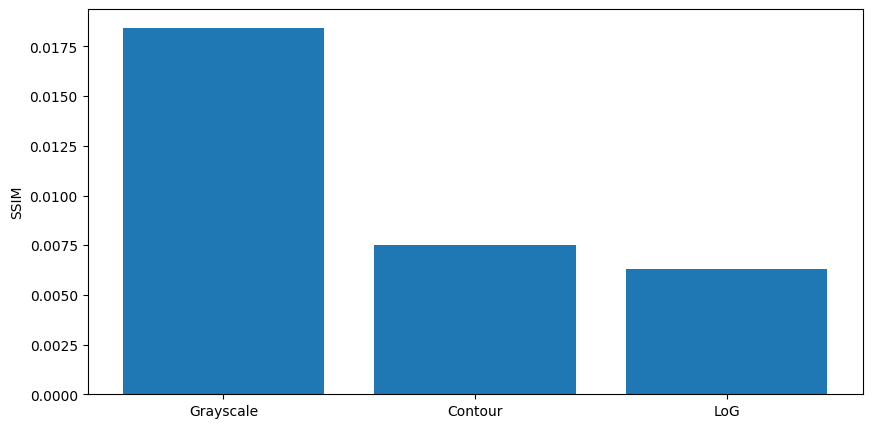

In [29]:
from skimage.metrics import structural_similarity as ssim

original_image = image_processing_dict[i]['grayscale']
# Convert PyTorch tensors to numpy arrays
original_np = original_image.cpu().detach().numpy().squeeze()
grayscale_response_np = grayscale_response.cpu().detach().numpy().squeeze()
contour_response_np = contour_response.cpu().detach().numpy().squeeze()
LoG_response_np = LoG_response.cpu().detach().numpy().squeeze()

# Make sure that the data types are float32 for SSIM (if not already)
original_np = original_np.astype(np.float32)
grayscale_response_np = grayscale_response_np.astype(np.float32)
contour_response_np = contour_response_np.astype(np.float32)
LoG_response_np = LoG_response_np.astype(np.float32)

# Set the data_range based on your images' range (here assuming 0-1)
data_range = 1.0

# Calculate SSIM for each pair (original vs. phosphene response)
ssim_grayscale = ssim(original_np, grayscale_response_np, data_range=data_range)
ssim_contour   = ssim(original_np, contour_response_np, data_range=data_range)
ssim_LoG       = ssim(original_np, LoG_response_np, data_range=data_range)

print("SSIM for Grayscale Response: ", ssim_grayscale)
print("SSIM for Contour Response: ", ssim_contour)
print("SSIM for LoG Response: ", ssim_LoG)

# show ssims in a bar plot
plt.figure(figsize=(10, 5))
plt.bar(['Grayscale', 'Contour', 'LoG'], [ssim_grayscale, ssim_contour, ssim_LoG])
plt.ylabel('SSIM')
plt.show()

SSIM for Grayscale Stimulus vs. Response:  0.016557737844267402
SSIM for Contour Stimulus vs. Response:  0.7840996922444857
SSIM for LoG Stimulus vs. Response:  0.4085735405443767


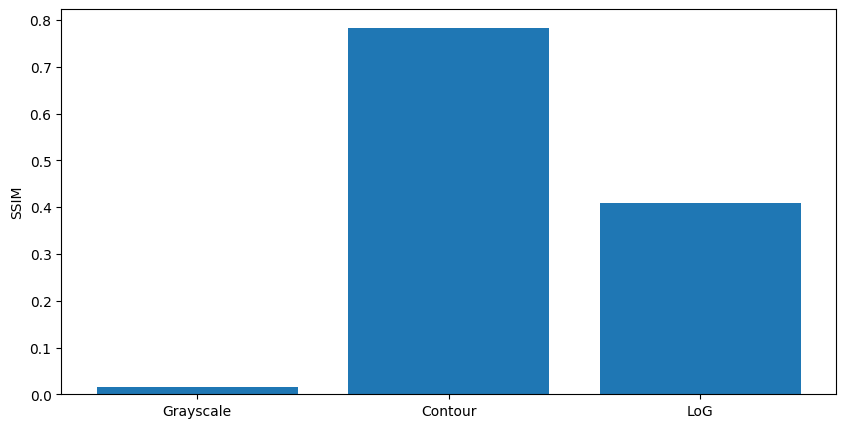

In [30]:
# 1) Grayscale Stimulus vs. Grayscale Response
grayscale_stim_np = grayscale_stim.cpu().detach().numpy().squeeze()
grayscale_response_np = grayscale_response.cpu().detach().numpy().squeeze()

# Ensure data is float32 and values are in the same range; here we assume they are normalized between 0 and 1.
grayscale_stim_np = grayscale_stim_np.astype(np.float32)
grayscale_response_np = grayscale_response_np.astype(np.float32)

# Calculate SSIM; set data_range to the difference between max and min in the stimulus
data_range_grayscale = grayscale_stim_np.max() - grayscale_stim_np.min()
ssim_grayscale = ssim(grayscale_stim_np, grayscale_response_np, data_range=data_range_grayscale)

# 2) Contour Stimulus vs. Contour Response
contour_stim_np = contour_stim.cpu().detach().numpy().squeeze()
contour_response_np = contour_response.cpu().detach().numpy().squeeze()

contour_stim_np = contour_stim_np.astype(np.float32)
contour_response_np = contour_response_np.astype(np.float32)

data_range_contour = contour_stim_np.max() - contour_stim_np.min()
ssim_contour = ssim(contour_stim_np, contour_response_np, data_range=data_range_contour)

# 3) LoG Stimulus vs. LoG Response
LoG_stim_np = LoG_stim.cpu().detach().numpy().squeeze()
LoG_response_np = LoG_response.cpu().detach().numpy().squeeze()

LoG_stim_np = LoG_stim_np.astype(np.float32)
LoG_response_np = LoG_response_np.astype(np.float32)

data_range_LoG = LoG_stim_np.max() - LoG_stim_np.min()
ssim_LoG = ssim(LoG_stim_np, LoG_response_np, data_range=data_range_LoG)

print("SSIM for Grayscale Stimulus vs. Response: ", ssim_grayscale)
print("SSIM for Contour Stimulus vs. Response: ", ssim_contour)
print("SSIM for LoG Stimulus vs. Response: ", ssim_LoG)

# show ssims in a bar plot
plt.figure(figsize=(10, 5))
plt.bar(['Grayscale', 'Contour', 'LoG'], [ssim_grayscale, ssim_contour, ssim_LoG])
plt.ylabel('SSIM')
plt.show()